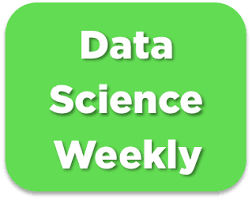

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [29]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

import seaborn as sns

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg"
from IPython.display import display

# Read file with labels

In [30]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [31]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [32]:
data.describe(include = "all")

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


In [33]:
mask = data["age"] < 70

In [34]:
data.columns

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')

In [35]:
print("Percentage of missing values: ")
display(100*data.isnull().sum()/data.shape[0])
# there are no missing data in the dataset, no imputer is needed

Percentage of missing values: 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

In [36]:
data["age_ratio_total_pages_visited"] = data["age"] / data["total_pages_visited"]
data["total_pages_visited_ratio_age"] = data["total_pages_visited"] / data["age"]
data["new_user_diff_total_pages_visited"] = data["new_user"] - data["total_pages_visited"]
data["total_pages_visited_sum_new_user"] = data["total_pages_visited"] + data["new_user"]
data["age_diff_total_pages_visited"] = data["age"] - data["total_pages_visited"]
data["new_user_ratio_total_pages_visited"] = data["new_user"] / data["total_pages_visited"]
data["total_pages_visited_ratio_new_user"] = data["total_pages_visited"] / data["new_user"]
data["total_pages_visited_multiply_new_user"] = data["total_pages_visited"] * data["new_user"]
data["new_user_sum_age"] = data["new_user"] + data["age"]
data["age_multiply_new_user"] = data["age"] - data["new_user"]


# Explore dataset

In [37]:
# # The dataset is quite big : you must create a sample of the dataset before making any visualizations !
# data_sample = data.sample(10000)

# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [38]:
features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited', 'age_ratio_total_pages_visited', 'total_pages_visited_ratio_age', 'new_user_diff_total_pages_visited', 'total_pages_visited_sum_new_user', 'age_diff_total_pages_visited', 'new_user_ratio_total_pages_visited', 'total_pages_visited_ratio_new_user', 'total_pages_visited_multiply_new_user', 'new_user_sum_age', 'age_multiply_new_user']
target_variable = 'converted'

In [39]:
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'age_ratio_total_pages_visited', 'total_pages_visited_ratio_age',
       'new_user_diff_total_pages_visited', 'total_pages_visited_sum_new_user',
       'age_diff_total_pages_visited', 'new_user_ratio_total_pages_visited',
       'total_pages_visited_ratio_new_user',
       'total_pages_visited_multiply_new_user', 'new_user_sum_age',
       'age_multiply_new_user'],
      dtype='object')



In [40]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.80, random_state=0, stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



## Training pipeline

In [41]:
numeric_features = ['age', 'total_pages_visited'] # Names of numeric columns in X_train/X_test

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()) # standardization
])

In [42]:
categorical_features = ['country', 'new_user', 'source'] # Names of categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

In [43]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [44]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5, :])
print()

Performing preprocessings on train set...
...Done.
[[ 0.41624558 -0.26444566  1.          0.          0.          1.
   1.          0.        ]
 [-1.15215372  3.33631724  0.          0.          1.          0.
   0.          1.        ]
 [ 0.65753778  1.83599937  0.          0.          1.          0.
   0.          1.        ]
 [-0.06633882 -1.16463638  0.          0.          1.          0.
   0.          1.        ]
 [ 0.77818388  1.23587222  0.          0.          0.          1.
   1.          0.        ]]



In [45]:
print(X)


        country  age  new_user  source  total_pages_visited  \
0         China   22         1  Direct                    2   
1            UK   21         1     Ads                    3   
2       Germany   20         0     Seo                   14   
3            US   23         1     Seo                    3   
4            US   28         1  Direct                    3   
...         ...  ...       ...     ...                  ...   
284575       US   36         1     Ads                    1   
284576       US   31         1     Seo                    2   
284577       US   41         1     Seo                    5   
284578       US   31         1  Direct                    4   
284579       US   26         0     Ads                    3   

        age_ratio_total_pages_visited  total_pages_visited_ratio_age  \
0                           11.000000                       0.090909   
1                            7.000000                       0.142857   
2                          

In [46]:
from lightgbm import LGBMClassifier

# Best hyperparameters :  {'bagging_fraction': 0.5, 'feature_fraction': 0.9, 'learning_rate': 0.05, 'metric': 'custom', 'min_data_in_leaf': 50, 'n_jobs': -1, 'num_iterations': 100, 'num_leaves': 31, 'objective': 'binary'}
# Best f1-score :  0.7649708365782073
lightgbm = LGBMClassifier()

params = {
# 'num_iterations': [100, 200, 300],
# 'num_iterations': [100],
'n_jobs': [-1],
'objective' : ['binary'],
'num_leaves' : [31],
# 'learning_rate': [0.01, 0.05],
'learning_rate': [0.05],
'feature_fraction': [0.9],
'bagging_fraction': [0.5],
'min_data_in_leaf': [50],
# 'metric': ['custom'],
# 'custom_eval_metric_name': ['f1'],
# 'explain_level': [0],
}

print("Grid search...")

# Grid of values to be tested

print(params)
best_lightgbm = GridSearchCV(lightgbm, param_grid = params, cv = 10, scoring = "f1", verbose=True) # cv : the number of folds to be used for CV
best_lightgbm.fit(X_train, Y_train)
print("...Done.")

print("Best hyperparameters : ", best_lightgbm.best_params_)
print("Best f1-score : ", best_lightgbm.best_score_)


Grid search...
{'n_jobs': [-1], 'objective': ['binary'], 'num_leaves': [31], 'learning_rate': [0.05], 'feature_fraction': [0.9], 'bagging_fraction': [0.5], 'min_data_in_leaf': [50]}
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_i

In [47]:
# print("Grid search...")
# xgboost = XGBClassifier()
#
# # Grid of values to be tested
# params = {
#     'booster': ['gbtree', 'gblinear', 'dart'],
#     'learning_rate': [0.01, 0.1, 0.5, 1],
#     #'max_depth': [2, 4, 6], # exactly the same role as in scikit-learn
#     #'max_depth': [6, 8, 10, 12], # iteration 2
#     'max_depth': [6], # iteration 3
#     #'min_child_weight': [1, 2, 3], # effect is more or less similar to min_samples_leaf and min_samples_split
#     #'min_child_weight': [3, 4, 5, 6], # iteration 2
#     'min_child_weight': [6], # iteration 3
#     #'n_estimators': [2, 4, 6, 8,] # exactly the same role as in scikit-learn
#     # 'n_estimators': [8, 10, 12, 14, 16] # iteration 2
#     'n_estimators': [14] # iteration 3
# }
# print(params)
# best_xgboost = GridSearchCV(xgboost, param_grid = params, cv = 5, scoring = "f1", verbose=True) # cv : the number of folds to be used for CV
# best_xgboost.fit(X_train, Y_train)
# print("...Done.")
#
# print("Best hyperparameters : ", best_xgboost.best_params_)
# print("Best f1-score : ", best_xgboost.best_score_)


In [48]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = best_lightgbm.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 1 0 ... 0 0 0]



## Test pipeline

In [49]:
print("Performing preprocessings on test set...")

print("Encoding categorical features and standardizing numerical features...")
X_test = preprocessor.transform(X_test) 
print('...Done.')
print(X_test[0:5,:]) 
print()


Performing preprocessings on test set...
Encoding categorical features and standardizing numerical features...
...Done.
[[ 1.14012217 -0.56450923  0.          0.          0.          1.
   1.          0.        ]
 [-0.06633882 -0.56450923  0.          0.          1.          0.
   0.          0.        ]
 [-1.63473811  0.03561792  0.          1.          0.          0.
   0.          1.        ]
 [-0.30763102 -0.56450923  0.          0.          1.          1.
   1.          0.        ]
 [-0.18698492 -0.8645728   0.          0.          1.          1.
   0.          1.        ]]



In [50]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = best_lightgbm.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



## Performance assessment

In [51]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

# print accuracy_score
print("accuracy_score on train set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy_score on test set : ", accuracy_score(Y_test, Y_test_pred))

f1-score on train set :  0.7796711509715994
f1-score on test set :  0.7592400178120825
accuracy_score on train set :  0.9870510928385691
accuracy_score on test set :  0.9857509311968515


In [52]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[54875   205]
 [  532  1304]]

Confusion matrix on test set : 
[[219305   1015]
 [  2229   5115]]



# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [53]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

best_lightgbm.fit(X,Y)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current va

GridSearchCV(cv=10, estimator=LGBMClassifier(),
             param_grid={'bagging_fraction': [0.5], 'feature_fraction': [0.9],
                         'learning_rate': [0.05], 'min_data_in_leaf': [50],
                         'n_jobs': [-1], 'num_leaves': [31],
                         'objective': ['binary']},
             scoring='f1', verbose=True)

In [54]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

data_without_labels["age_ratio_total_pages_visited"] = data_without_labels["age"] / data_without_labels["total_pages_visited"]
data_without_labels["total_pages_visited_ratio_age"] = data_without_labels["total_pages_visited"] / data_without_labels["age"]
data_without_labels["new_user_diff_total_pages_visited"] = data_without_labels["new_user"] - data_without_labels["total_pages_visited"]
data_without_labels["total_pages_visited_sum_new_user"] = data_without_labels["total_pages_visited"] + data_without_labels["new_user"]
data_without_labels["age_diff_total_pages_visited"] = data_without_labels["age"] - data_without_labels["total_pages_visited"]
data_without_labels["new_user_ratio_total_pages_visited"] = data_without_labels["new_user"] / data_without_labels["total_pages_visited"]
data_without_labels["total_pages_visited_ratio_new_user"] = data_without_labels["total_pages_visited"] / data_without_labels["new_user"]
data_without_labels["total_pages_visited_multiply_new_user"] = data_without_labels["total_pages_visited"] * data_without_labels["new_user"]
data_without_labels["new_user_sum_age"] = data_without_labels["new_user"] + data_without_labels["age"]
data_without_labels["age_multiply_new_user"] = data_without_labels["age"] - data_without_labels["new_user"]

# Warning : check consistency of features_list (must be the same than the features
# used by your best classifier)
features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited', 'age_ratio_total_pages_visited', 'total_pages_visited_ratio_age', 'new_user_diff_total_pages_visited', 'total_pages_visited_sum_new_user', 'age_diff_total_pages_visited', 'new_user_ratio_total_pages_visited', 'total_pages_visited_ratio_new_user', 'total_pages_visited_multiply_new_user', 'new_user_sum_age', 'age_multiply_new_user']
X_without_labels = data_without_labels.loc[:, features_list]

Prediction set (without labels) : (31620, 5)


In [55]:
# # VERSION OK
#
# # Read data without labels
# data_without_labels = pd.read_csv('conversion_data_test.csv')
# print('Prediction set (without labels) :', data_without_labels.shape)
#
# # Warning : check consistency of features_list (must be the same than the features
# # used by your best classifier)
# features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
# X_without_labels = data_without_labels.loc[:, features_list]

In [56]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.30763102  3.33631724  0.          1.          0.          0.
   0.          1.        ]
 [-1.03150762  0.03561792  0.          1.          0.          1.
   1.          0.        ]
 [ 0.17495338 -1.16463638  0.          0.          0.          1.
   0.          1.        ]
 [ 0.17495338  0.33568149  0.          0.          1.          1.
   0.          0.        ]
 [-0.66956932 -0.56450923  0.          0.          0.          0.
   0.          1.        ]]


In [57]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': best_lightgbm.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_LV_test.csv', index=False)


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**